Implementation from Google:

In [2]:
# Copyright 2017 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Abstract class for sampling methods.

Provides interface to sampling methods that allow same signature
for select_batch.  Each subclass implements select_batch_ with the desired
signature for readability.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import numpy as np

class SamplingMethod(object):
  __metaclass__ = abc.ABCMeta

  @abc.abstractmethod
  def __init__(self, X, y, seed, **kwargs):
    self.X = X
    self.y = y
    self.seed = seed

  def flatten_X(self):
    shape = self.X.shape
    flat_X = self.X
    if len(shape) > 2:
      flat_X = np.reshape(self.X, (shape[0],np.product(shape[1:])))
    return flat_X


  @abc.abstractmethod
  def select_batch_(self):
    return

  def select_batch(self, **kwargs):
    return self.select_batch_(**kwargs)

  def to_dict(self):
    return None

In [4]:
# Copyright 2017 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Returns points that minimizes the maximum distance of any point to a center.

Implements the k-Center-Greedy method in
Ozan Sener and Silvio Savarese.  A Geometric Approach to Active Learning for
Convolutional Neural Networks. https://arxiv.org/abs/1708.00489 2017

Distance metric defaults to l2 distance.  Features used to calculate distance
are either raw features or if a model has transform method then uses the output
of model.transform(X).

Can be extended to a robust k centers algorithm that ignores a certain number of
outlier datapoints.  Resulting centers are solution to multiple integer program.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from sklearn.metrics import pairwise_distances


class kCenterGreedy(SamplingMethod):

  def __init__(self, X, y, seed, metric='euclidean'):
    self.X = X
    self.y = y
    self.flat_X = self.flatten_X()
    self.name = 'kcenter'
    self.features = self.flat_X
    self.metric = metric
    self.min_distances = None
    self.n_obs = self.X.shape[0]
    self.already_selected = []

  def update_distances(self, cluster_centers, only_new=True, reset_dist=False):
    """Update min distances given cluster centers.

    Args:
      cluster_centers: indices of cluster centers
      only_new: only calculate distance for newly selected points and update
        min_distances.
      rest_dist: whether to reset min_distances.
    """

    if reset_dist:
      self.min_distances = None
    if only_new:
      cluster_centers = [d for d in cluster_centers
                         if d not in self.already_selected]
    if cluster_centers:
      # Update min_distances for all examples given new cluster center.
      x = self.features[cluster_centers]
      dist = pairwise_distances(self.features, x, metric=self.metric)

      if self.min_distances is None:
        self.min_distances = np.min(dist, axis=1).reshape(-1,1)
      else:
        self.min_distances = np.minimum(self.min_distances, dist)

  def select_batch_(self, model, already_selected, N, **kwargs):
    """
    Diversity promoting active learning method that greedily forms a batch
    to minimize the maximum distance to a cluster center among all unlabeled
    datapoints.

    Args:
      model: model with scikit-like API with decision_function implemented
      already_selected: index of datapoints already selected
      N: batch size

    Returns:
      indices of points selected to minimize distance to cluster centers
    """

    try:
      # Assumes that the transform function takes in original data and not
      # flattened data.
      print('Getting transformed features...')
      self.features = model.transform(self.X)
      print('Calculating distances...')
      self.update_distances(already_selected, only_new=False, reset_dist=True)
    except:
      print('Using flat_X as features.')
      self.update_distances(already_selected, only_new=True, reset_dist=False)

    new_batch = []

    for _ in range(N):
      if self.already_selected is None:
        # Initialize centers with a randomly selected datapoint
        ind = np.random.choice(np.arange(self.n_obs))
      else:
        ind = np.argmax(self.min_distances)
      # New examples should not be in already selected since those points
      # should have min_distance of zero to a cluster center.
      assert ind not in already_selected

      self.update_distances([ind], only_new=True, reset_dist=False)
      new_batch.append(ind)
    print('Maximum distance from cluster centers is %0.2f'
            % max(self.min_distances))


    self.already_selected = already_selected

    return new_batch


Coresets using K-Greedy Centers Example

1. Generate Synthetic Data: We use make_blobs from sklearn.datasets to create a synthetic dataset with 100 samples and 5 centers in a 2D space.
2. Initialize kCenterGreedy: We initialize the kCenterGreedy class with our synthetic dataset.
3. Select a Batch of Points: We call the select_batch_ method to select 5 points that act as cluster centers. These points are chosen to minimize the maximum distance from any point in the dataset to the nearest center.

In [1]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

class SamplingMethod:
    pass

class kCenterGreedy(SamplingMethod):

  def __init__(self, X, y=None, seed=None, metric='euclidean'):
    self.X = X
    self.y = y
    self.flat_X = X
    self.name = 'kcenter'
    self.features = self.flat_X
    self.metric = metric
    self.min_distances = None
    self.n_obs = self.X.shape[0]
    self.already_selected = []

  def update_distances(self, cluster_centers, only_new=True, reset_dist=False):
    if reset_dist:
      self.min_distances = None
    if only_new:
      cluster_centers = [d for d in cluster_centers if d not in self.already_selected]
    if cluster_centers:
      x = self.features[cluster_centers]
      dist = pairwise_distances(self.features, x, metric=self.metric)
      if self.min_distances is None:
        self.min_distances = np.min(dist, axis=1).reshape(-1, 1)
      else:
        self.min_distances = np.minimum(self.min_distances, dist)

  def select_batch_(self, already_selected, N):
    self.update_distances(already_selected, only_new=False, reset_dist=True)
    new_batch = []
    for _ in range(N):
      if self.already_selected is None:
        ind = np.random.choice(np.arange(self.n_obs))
      else:
        ind = np.argmax(self.min_distances)
      assert ind not in already_selected
      self.update_distances([ind], only_new=True, reset_dist=False)
      new_batch.append(ind)
    self.already_selected = already_selected + new_batch
    return new_batch

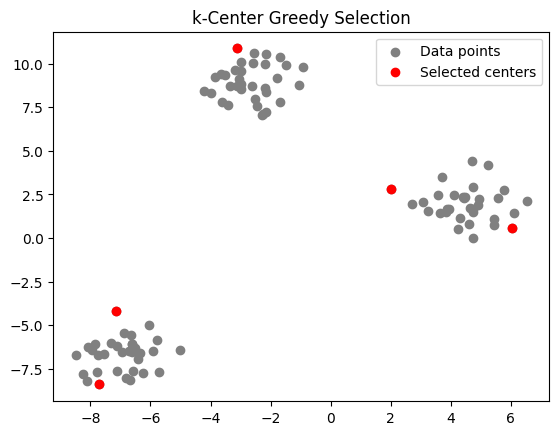

In [4]:
# generate data
X, _ = make_blobs(n_samples=100, centers=3, n_features=2, random_state=42)

# initialize kCenterGreedy
kcenter = kCenterGreedy(X)

# select a batch of points
N = 5
selected_indices = kcenter.select_batch_(already_selected=[], N=N)

# plot the results
plt.scatter(X[:, 0], X[:, 1], c='gray', label='Data points')
plt.scatter(X[selected_indices, 0], X[selected_indices, 1], c='red', label='Selected centers')
plt.legend()
plt.title("k-Center Greedy Selection")
plt.show()

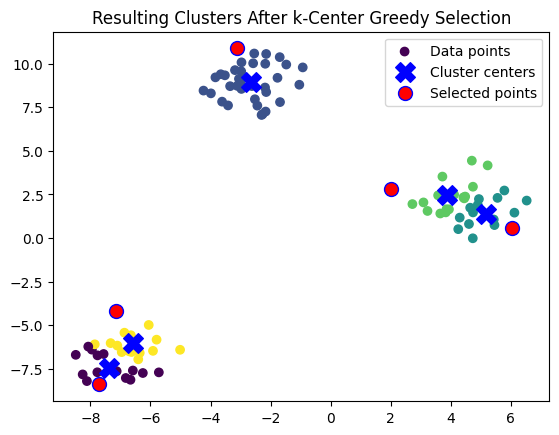

In [5]:
from sklearn.cluster import KMeans

# Fit KMeans with the selected points as initial cluster centers
kmeans = KMeans(n_clusters=N, init=X[selected_indices], n_init=1).fit(X)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

# Plot the results
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', label='Data points')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='blue', s=200, marker='X', label='Cluster centers')
plt.scatter(X[selected_indices, 0], X[selected_indices, 1], c='red', edgecolor='blue', facecolor='none', s=100, label='Selected points')
plt.legend()
plt.title("Resulting Clusters After k-Center Greedy Selection")
plt.show()

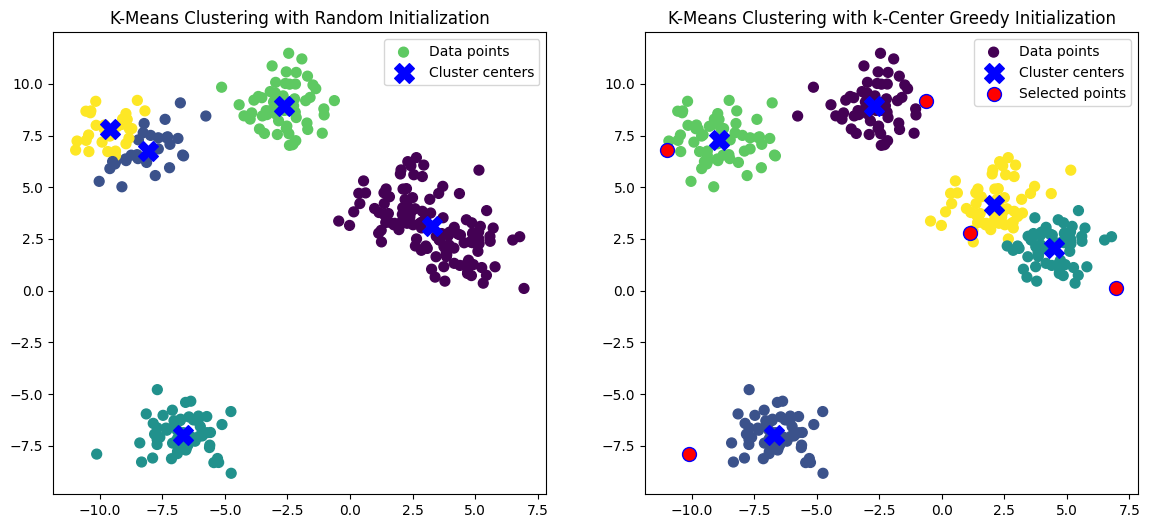

In [10]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# Define the k-center greedy algorithm
class kCenterGreedy:
    def __init__(self, X, y=None, seed=None, metric='euclidean'):
        self.X = X
        self.y = y
        self.features = X
        self.metric = metric
        self.min_distances = None
        self.n_obs = self.X.shape[0]
        self.already_selected = []

    def update_distances(self, cluster_centers, only_new=True, reset_dist=False):
        if reset_dist:
            self.min_distances = None
        if only_new:
            cluster_centers = [d for d in cluster_centers if d not in self.already_selected]
        if cluster_centers:
            x = self.features[cluster_centers]
            dist = pairwise_distances(self.features, x, metric=self.metric)
            if self.min_distances is None:
                self.min_distances = np.min(dist, axis=1).reshape(-1, 1)
            else:
                self.min_distances = np.minimum(self.min_distances, dist)

    def select_batch_(self, already_selected, N):
        self.update_distances(already_selected, only_new=False, reset_dist=True)
        new_batch = []
        for _ in range(N):
            if self.already_selected is None:
                ind = np.random.choice(np.arange(self.n_obs))
            else:
                ind = np.argmax(self.min_distances)
            assert ind not in already_selected
            self.update_distances([ind], only_new=True, reset_dist=False)
            new_batch.append(ind)
        self.already_selected = already_selected + new_batch
        return new_batch

# Generate synthetic data
X, _ = make_blobs(n_samples=300, centers=5, n_features=2, random_state=42)

# Initialize kCenterGreedy
k_center_greedy = kCenterGreedy(X)

# Select a batch of points
N = 5
selected_indices = k_center_greedy.select_batch_([], N)

# Before: KMeans with random initialization
kmeans_random = KMeans(n_clusters=N, random_state=42).fit(X)
labels_random = kmeans_random.labels_
centers_random = kmeans_random.cluster_centers_

# After: KMeans with selected points as initial centers
kmeans_selected = KMeans(n_clusters=N, init=X[selected_indices], n_init=1).fit(X)
labels_selected = kmeans_selected.labels_
centers_selected = kmeans_selected.cluster_centers_

# Plot before clustering
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels_random, cmap='viridis', s=50, label='Data points')
plt.scatter(centers_random[:, 0], centers_random[:, 1], c='blue', s=200, marker='X', label='Cluster centers')
plt.title("K-Means Clustering with Random Initialization")
plt.legend()

# Plot after clustering
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=labels_selected, cmap='viridis', s=50, label='Data points')
plt.scatter(centers_selected[:, 0], centers_selected[:, 1], c='blue', s=200, marker='X', label='Cluster centers')
plt.scatter(X[selected_indices, 0], X[selected_indices, 1], c='red', edgecolor='blue', facecolor='none', s=100, label='Selected points')
plt.title("K-Means Clustering with k-Center Greedy Initialization")
plt.legend()

plt.show()
